In [1]:
import csv
import cudf, cuml
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split, KFold
from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
import matplotlib.pyplot as plt
print('cuML version',cuml.__version__)

cuML version 23.04.01


In [2]:
#Load Data
edge_list=[]
paths={
    "Data API":"./data/Data_API_mapped.csv",
    "Art":"./data/Art_mapped.csv",
    "Collectible":"./data/Collectible_mapped.csv",
    "Games":"./data/Games_mapped.csv",
    "Metaverse":"./data/Metaverse_mapped.csv",
    "Utility":"./data/Utility_mapped.csv",
    "Other":"./data/Other_mapped.csv"
    }
# for i,key in enumerate(paths):
#     filepath = paths[key]
#     with open(filepath, 'r', encoding='UTF-8') as f:
#         reader = csv.reader(f)
#         seller_address_list = []
#         buyer_address_list = []
#         for row in reader:
#             seller_address_list.append(row[0])
#             buyer_address_list.append(row[1])
#     edge_list.append(list(zip(seller_address_list, buyer_address_list)))
#     print("List {}: {}".format(i,key))

In [3]:
labels=['Art','Collectible','Games','Metaverse','Utility','Other']

In [4]:
# LOAD TRAINING DATA
train = cudf.read_csv(paths['Data API'])
print('train shape =', train.shape)
train.head()

train shape = (6071026, 8)


,0,1,0.0002,ETH,0.030318,Godsunchained,2019-11-30 00:00:00,Games
0,0,2,0.0013,ETH,0.197067,Godsunchained,2019-11-30 00:00:00,Games
1,0,1,0.0002,ETH,0.030318,Godsunchained,2019-11-30 00:00:00,Games
2,0,2,0.0022,ETH,0.333498,Godsunchained,2019-11-30 00:00:00,Games
3,0,2,0.0012,ETH,0.181908,Godsunchained,2019-11-30 00:00:00,Games
4,0,2,0.0018,ETH,0.272862,Godsunchained,2019-11-30 00:00:00,Games


In [5]:
from sklearn import preprocessing
X=train.iloc[:,0:2]
y=train.iloc[:,7]
le = preprocessing.LabelEncoder()
le.fit(labels)
y_trans=le.transform(y.to_numpy())
# CREATE 20% VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(X,y_trans,test_size=0.2, random_state=42)

In [6]:
# GRID SEARCH FOR OPTIMAL K
accs = []
for k in range(3,20):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    # Better to use knn.predict() but cuML v0.11.0 has bug
    # y_hat = knn.predict(X_test)
    y_hat_p = knn.predict(X_test)
    acc = (y_hat_p.to_pandas().values==y_test).sum()/y_test.shape[0]
    print("Finished for k={},acc={}".format(k,acc))
    accs.append(acc)

Finished for k=3,acc=0.8536228613596045
Finished for k=4,acc=0.8485158202150211
Finished for k=5,acc=0.8475802293844702
Finished for k=6,acc=0.8436978568710746
Finished for k=7,acc=0.8419642136507314
Finished for k=8,acc=0.8390223734687524
Finished for k=9,acc=0.8374666242795703
Finished for k=10,acc=0.835133412287536
Finished for k=11,acc=0.8334878924992959
Finished for k=12,acc=0.8315780024147468
Finished for k=13,acc=0.8300098994734008
Finished for k=14,acc=0.8284154418607715
Finished for k=15,acc=0.827057352706213
Finished for k=16,acc=0.8257700917307277
Finished for k=17,acc=0.8245437759325848
Finished for k=18,acc=0.8233174601344417
Finished for k=19,acc=0.8219503115616296


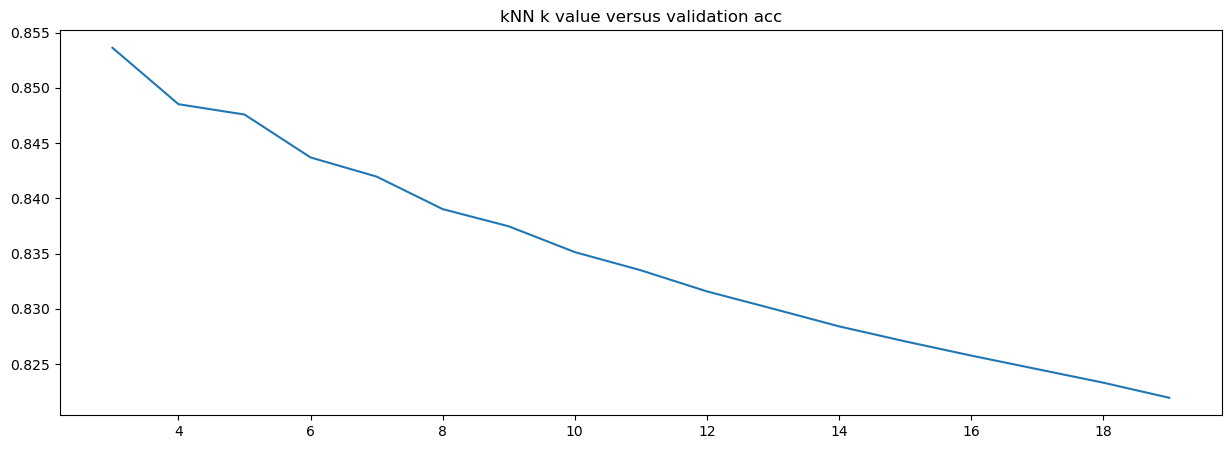

In [7]:
# PLOT GRID SEARCH RESULTS
plt.figure(figsize=(15,5))
plt.plot(range(3,20),accs)
plt.title('kNN k value versus validation acc')
plt.show()

In [8]:
#Plot KNN with related high accuracy
clf = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
y_hat_p = knn.predict(X_test)

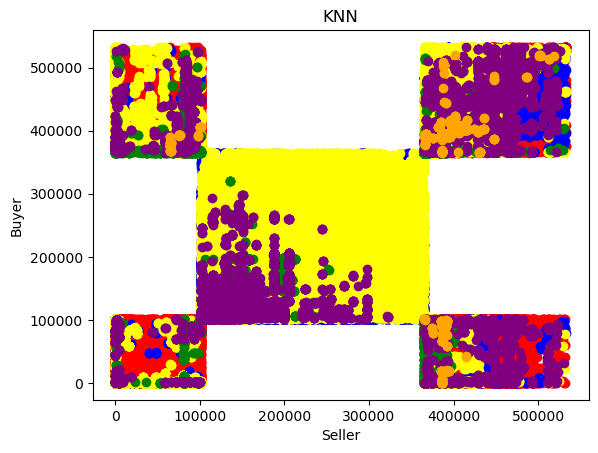

In [9]:
import cupy as cp
colors=['red','blue','yellow','green','purple','orange']
# Plotting decision region
data = cp.array(X_test.to_numpy())
y_hat_p=cp.array(y_hat_p.to_numpy())
data=cp.hstack((data, cp.reshape(y_hat_p, (-1, 1))))
data_by_label = {label: cp.array([]) for label in [0,1,2,3,4,5]}
for label in [0,1,2,3,4,5]:
    data_by_label[label] = data[data[:, 2] == label][:, :2]
# 绘制散点图
for label, color in zip([0,1,2,3,4,5], colors):
    plt.scatter(data_by_label[label][:, 0].get(), data_by_label[label][:, 1].get(), c=color, label=label)
plt.xlabel("Seller")
plt.ylabel("Buyer")
plt.title("KNN")
plt.show()

In [11]:
from cuml.cluster import KMeans as KMeans

kmeans = KMeans(n_clusters=6, max_iter=300, init='scalable-k-means++')
X_float=X.astype(float)
kmeans.fit(X_float)

KMeans()

In [12]:
results_df = X.copy()
results_df['predicted'] = kmeans.labels_
print(results_df)

In [13]:
import cupy as cp
colors=['red','blue','yellow','green','purple','orange']
# Plotting decision region
data = cp.array(results_df.to_numpy())

data_by_label = {label: cp.array([]) for label in [0,1,2,3,4,5]}
for label in [0,1,2,3,4,5]:
    data_by_label[label] = data[data[:, 2] == label][:, :2]
# 绘制散点图
for label, color in zip([0,1,2,3,4,5], colors):
    plt.scatter(data_by_label[label][:, 0].get(), data_by_label[label][:, 1].get(), c=color, label=label)
plt.xlabel("Seller")
plt.ylabel("Buyer")
plt.title("KMeans")
plt.show()

   0  1  predicted
0  0  2          4
1  0  1          4
2  0  2          4
3  0  2          4
4  0  2          4
